In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy import interpolate

In [3]:
# Agrega el directorio superior al path
sys.path.append(os.path.abspath('..'))

In [4]:
import stars.EDOs.Sistemas as eds
import stars.Utilez as eu

In [5]:
eu.plots.general()

In [6]:
# shooting
def Freq_solveNodos(system, in0, wmin, wmax, rmin=0, rmax=1e03, met='RK45', Rtol=1e-09, Atol=1e-10,
               limw=1e-14, alphB=1, nodos=0, info=False):
    """
    Implementación de un algoritmo de shooting usando un método de bisección para encontrar el valor de la 
    frecuencia w0, dado una amplitud central p0.

    In:
    system -> sitema de ecuaciones: eds.systemBS
    in0 -> condiciones iniciales del problema: [g0, n0, p0, p1] recordar que [g, g', N, N', Phi, Phi'] -> [g0, g1, n0, n1, p0, p1]
    wmin, wmax -> rango de valores en el que se buscará la frecuencia (recomendado añadir un check al código que verifique que wmin<wmax)
    rmax, rmin -> intervalo que se discretizará, por defecto rmin=0, rmax=1e03 (notar que lo q se busca es que alcance el límite en w0)
    met -> metodología usada por solve_ivp, las opciones son: 'DOP853', 'LSODA', 'RK45', por defecto está este último
    Rtol, Atol=1e-10 -> representan la tolerancia relativa y absoluta al usar solve_ivp, por defecto son Rtol=1e-09, Atol=1e-10
    limw -> representa la diferencia limítrofe que aceptaremos: abs((wmax-wmin)/2)<=limw Por defecto es limw=1e-14 
    alphB -> Valor de alphaB, por defecto alphB=1
    nodos -> los nodos de la configuracion
    info -> Imprime información complementaria, por defecto info=False

    Out:
    w0, rTemp, nodosPosit  -> valor de la frecuencia encontrada, el radio máximo de la iteración y la posición de los nodos
    """
    
    print('Finding a profile with ', nodos, 'nodes')
    
    def Sig(r, yV, arg): return yV[2]
    def dSig(r, yV, arg): return yV[3]

    # establece las direcciones
    Sig.direction = 0  # como pueden ser varios nodos se pone 0. Notar que no hay acción que tomar, solo almacenamos 
    dSig.direction = 0

    while True:
        w0 = (wmax+wmin)/2
        arg = [w0, alphB]

        sol = solve_ivp(system, [rmin, rmax], in0, events=(Sig, dSig),
                         args=(arg,), method=met,  rtol=Rtol, atol=Atol)
        
        if info:
            plt.plot(sol.t, sol.y[2], label=r'$\omega=%3.2f$'%w0)
            plt.legend(frameon=False)
            plt.show()
        
        if sol.t_events[1].size == nodos+1 and sol.t_events[0].size == nodos and sol.t[-1]==rmax:
            print('Found', w0)
            rTemp = sol.t[-1]
            nodosPosit = sol.t_events[0]
            break
        elif sol.t_events[1].size > nodos+1:  # una vez por nodo
            if sol.t_events[0].size > nodos:  # dos veces por nodo
                wmax = w0
                rTemp = sol.t_events[0][-1]
            else:  # si pasa por cero más veces que 2*nodos se aumenta la w, sino se disminuye
                wmin = w0
                rTemp = sol.t_events[1][-1]
        elif sol.t_events[1].size <= nodos+1:
            if sol.t_events[0].size > nodos:  # dos veces por nodo
                wmax = w0
                rTemp = sol.t_events[0][-1]
            else:
                wmin = w0
                rTemp = sol.t_events[1][-1]

        # checking the lim freq.
        if abs((wmax-wmin)/2)<=limw:
            print('Maxima precisión alcanzada', w0, 'radio', rTemp)
            nodosPosit = sol.t_events[0]
            break
        
        if nodos==0:
            nodosPosit = None

    return w0, rTemp, nodosPosit 

In [22]:
# [g0, n0, p0, p1]
wmin, wmax = 0, 500
p0 = 0.1 #0.175/2 
in0 = [1, 1, p0, 0]
nodosData = [0, 1, 2, 3]
rmax = 100
alphB = 1

dataProf = []
for i in nodosData:
    w, rMax, nPso = Freq_solveNodos(eds.systemBS, in0, wmin, wmax, alphB=alphB, nodos=i,
                                    info=False, rmax=rmax, limw=1e-8)
    dataProf.append([w, rMax, p0, nPso])

Finding a profile with  0 nodes
Maxima precisión alcanzada 1.1639281146926805 radio 26.028993926722677
Finding a profile with  1 nodes
Maxima precisión alcanzada 1.2284717377042398 radio 39.11536302055951
Finding a profile with  2 nodes
Maxima precisión alcanzada 1.258857038919814 radio 46.528642286050555
Finding a profile with  3 nodes
Maxima precisión alcanzada 1.27829572011251 radio 57.51330229978298


In [23]:
dataProf
# [[1141885.5687833456, 22.17056219054985, array([22.17056219])]] para 1
# [[66.57151619717479, 17.707877203509415, array([], dtype=float64)]] pra 0.5


[[1.1639281146926805, 26.028993926722677, 0.1, array([], dtype=float64)],
 [1.2284717377042398,
  39.11536302055951,
  0.1,
  array([ 5.23380946, 39.11536302])],
 [1.258857038919814,
  46.528642286050555,
  0.1,
  array([ 4.69455648, 11.91545658, 46.52864229])],
 [1.27829572011251,
  57.51330229978298,
  0.1,
  array([ 4.43388255, 10.68227819, 19.26456822])]]

In [24]:
# [g0, n0, p0, p1]

soluciones = []
for i in range(len(dataProf)):
    rmin, rmax = 0, dataProf[i][1]
    w = dataProf[i][0]
    npt = 5000
    rspan = np.linspace(rmin, rmax, npt)
    
    
    p0 = dataProf[i][2] #.3
    in0 = [1, 1, p0, 0]  # [g0, n0, Phi0, Phi'0]
    arg = [w, alphB]
    
    met = 'RK45'
    Rtol = 1e-09
    Atol = 1e-10
    sol2 = solve_ivp(eds.systemBS, [rmin, rmax], in0, t_eval=rspan, args=(arg,), method=met, rtol=Rtol, atol=Atol)
    soluciones.append(sol2)

In [25]:
# Escalando
valC = []
for i in range(len(dataProf)):
    sol2 = soluciones[i]
    Nmax = sol2.y[1][-1]
    gmax = sol2.y[0][-1]
    
    c = eu.tools.escalamiento(Nmax, gmax)  # constante de escalamiento
    valC.append(c)

#valC[0]*dataProf[0][0]

In [26]:
# escalando
dens = lambda w, NN, gg, phi, dphi: ((w/NN)**2+1)*phi**2+(dphi/gg)**2  # densidad

valw, perfEsc, densDat = [], [], []
for i in range(len(dataProf)):
    rmin, rmax = 0, dataProf[i][1]
    rspan = np.linspace(0, rmax, npt)  # np.logspace(np.log10(1e-8), np.log10(rmax), npt)
    
    c = valC[i]
    w = dataProf[i][0]
    arg = [w*c, 1]
    
    p0 = dataProf[i][2] #.3
    in0 = [1, 1*c, p0, 0]  # [g0, n0, Phi0, Phi'0]
    
    sol2 = solve_ivp(eds.systemBS, [rmin, rmax], in0, t_eval=rspan, args=(arg,), method=met, rtol=Rtol, atol=Atol)  # usamos la librería de Python
    densVal = dens(arg[0], sol2.y[1], sol2.y[0], sol2.y[2], sol2.y[3])
    
    valw.append(arg[0])
    perfEsc.append(sol2)
    densDat.append(densVal)


$$
\rho =\alpha_B \left[\left(\frac{\omega^2}{N^2}+m^2\right)\varphi^2+\frac{\varphi'^2}{g^2}\right]
$$

/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_87540/2458286067.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4.5),


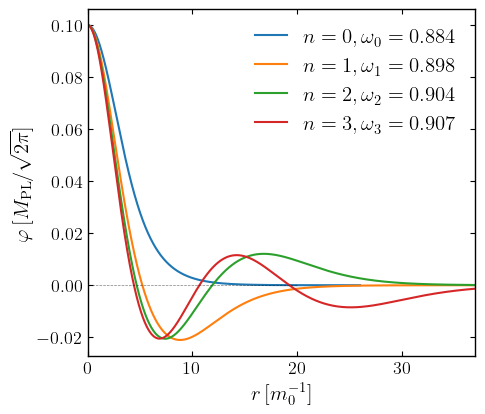

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4.5),
                       sharex=False, sharey=False,
                       gridspec_kw=dict(hspace=0.0, wspace=.28))

for i in range(len(dataProf)):
    sol2 = perfEsc[i]
    w = valw[i]
    ax.plot(sol2.t, sol2.y[2], lw=1.5, label=r'$n = %d, \omega_%d=%4.3f$'%(i, i, w))  # 'indianred'

ax.hlines(y=0, xmin=0, xmax=20, ls='--', lw=0.5, color='k', alpha=0.5)
#ax.set_ylim(-0.03, .11)
ax.set_xlim(0, 37)
ax.legend(frameon=False)

ax.set_ylabel(r'$\varphi \, [M_{\mathrm{PL}}/\sqrt{2\pi}]$')
ax.set_xlabel(r'$r \,[m_{0}^{-1}]$')

# Editando spines y limites
ax.tick_params(which='both', direction='in', right=True, top=True)  # , length=6, width=.5


#left, bottom, width, height = [0.3, 0.33, 0.4, 0.4]  # posición y dimensiones del insert
#ax1 = fig.add_axes([left, bottom, width, height])

#ax1.plot(sol2.t, sol2.y[2], lw=2, color='indianred', label=r'$\varphi = 1.0$')

#ax1.tick_params(which='both', direction='in', right=True, top=True)  # , length=6, width=.5

#ax1.set_ylim(-0.001, 0.31)
#ax1.set_xlim(-0.0, 2)

In [30]:
fig.savefig('Campoprofile.pdf', format='pdf', metadata=None, # dpi='figure',
        pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None, dpi=1000, 
        bbox_inches='tight'# Plot will be occupy a maximum of available space # bbox_inches=None,
       )

/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_87540/3990159338.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4.5),


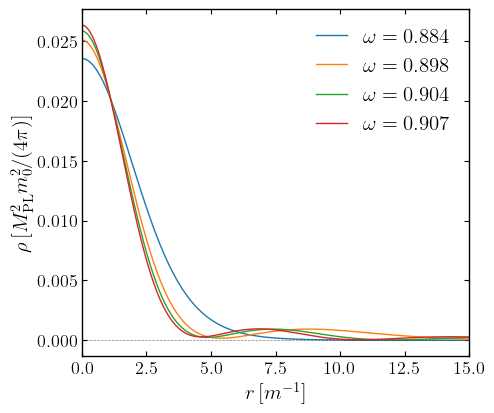

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4.5),
                       sharex=False, sharey=False,
                       gridspec_kw=dict(hspace=0.0, wspace=.28))

for i in range(len(dataProf)):
    densVal = densDat[i]
    sol2 = perfEsc[i]
    w = valw[i]
    ax.plot(sol2.t, densVal, lw=1, label=r'$\omega = %4.3f$'%w)  # 2, color='steelblue',

#ax.set_ylim(-0.001, 1.02)
ax.set_xlim(0, 15)
ax.legend(frameon=False)

ax.set_ylabel(r'$\rho \, [M_{\mathrm{PL}}^2 m_0^2/(4\pi)]$')
ax.set_xlabel(r'$r \,[m^{-1}]$')

# Editando spines y limites
ax.tick_params(which='both', direction='in', right=True, top=True)  # , length=6, width=.5

ax.hlines(y=0, xmin=0, xmax=20, ls='--', lw=0.5, color='k', alpha=0.5)

#left, bottom, width, height = [0.3, 0.33, 0.4, 0.4]  # posición y dimensiones del insert
#ax1 = fig.add_axes([left, bottom, width, height])

#ax1.plot(sol2.t, densVal, lw=2, color='steelblue', label=r'$\varphi = 1.0$')

#ax1.tick_params(which='both', direction='in', right=True, top=True)  # , length=6, width=.5
#ax1.set_ylim(-0.001, 1.02)
#ax1.set_xlim(-0.01, 1)

In [36]:
fig.savefig('Densidadprofile.pdf', format='pdf', metadata=None, # dpi='figure',
        pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None, dpi=1000, 
        bbox_inches='tight'# Plot will be occupy a maximum of available space # bbox_inches=None,
       )

/var/folders/mf/vfyq6zyn4l35gfd2kgq4k2q00000gn/T/ipykernel_87540/876474588.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4.5),


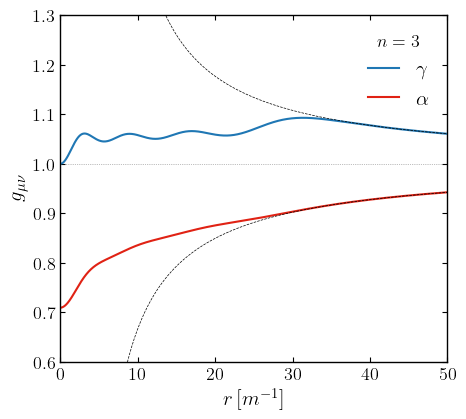

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4.5),
                       sharex=False, sharey=False,
                       gridspec_kw=dict(hspace=0.0, wspace=.28))

# Identificando el radio de Sch
mas = lambda r, g: r*(1-1/g**2)/2  # probar ecuación e unidades
masa = mas(sol2.t, sol2.y[0])[-1]  # masa (hablar de m99)
rSch = 2*masa  # radio de Sch
_, idx = eu.tools.find_nearest(sol2.t, rSch)
xvalSch = sol2.t[idx:]

# Sch g00 (recordar q N^2)
g00Sc = lambda r, masa: np.sqrt(1-2*masa/r)

## g_{rr} = gg
ax.plot(sol2.t, sol2.y[0], lw=1.5, label=r'$\gamma$')
ax.plot(xvalSch, 1/g00Sc(xvalSch, masa), c='k', ls='--', lw=0.5)  #label=r'$g^{Sch}_{rr}$'

## g_{tt} = NN
ax.plot(sol2.t, sol2.y[1], lw=1.5, c='#e02214', label=r'$\alpha$')
ax.plot(xvalSch, g00Sc(xvalSch, masa), c='k', ls='--', lw=0.5) # , label=r'$g_{tt}$'

ax.set_ylim(0.6, 1.3)
ax.set_xlim(-0.01, 50)
ax.legend(frameon=False, title=r'$n=%d$'%nodosData[-1])

ax.set_ylabel(r'$g_{\mu\nu}$')
ax.set_xlabel(r'$r \,[m^{-1}]$')


#ax.hlines(y=0, xmin=0, xmax=10)
# Editando spines y limites
ax.tick_params(which='both', direction='in', right=True, top=True)  # , length=6, width=.5

ax.hlines(y=1, xmin=0, xmax=50, ls=':', lw=0.5, color='k', alpha=0.5)


#left, bottom, width, height = [0.3, 0.33, 0.4, 0.4]  # posición y dimensiones del insert
#ax1 = fig.add_axes([left, bottom, width, height])

#ax1.plot(sol2.t, densVal, lw=2, color='indianred', label=r'$\varphi = 1.0$')

#ax1.tick_params(which='both', direction='in', right=True, top=True)  # , length=6, width=.5
#ax1.set_ylim(-0.001, 1.02)
#ax1.set_xlim(-0.01, 1)

In [51]:
fig.savefig('metricprofile.pdf', format='pdf', metadata=None, # dpi='figure',
        pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None, dpi=1000, 
        bbox_inches='tight'# Plot will be occupy a maximum of available space # bbox_inches=None,
       )